In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import librosa
import os
import soundfile as sf
import torch, torchaudio
import torchaudio.functional as f
import re
from scipy.signal import resample
from sklearn.metrics import accuracy_score

2024-06-20 14:05:29.161171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 14:05:29.161317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 14:05:29.329788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Dataset

In [3]:
dir = '/kaggle/input/speech-accent-archive/recordings/recordings'
audio_list = os.listdir(dir)

# Pre-Processing

## Extracting MFCC

In [4]:
target_sample_rate = 44100

def extract_features(audio_file, n_fft=128, hop_length=32, n_mfcc=13):
    y, sr = sf.read(audio_file)
    
    # Check if sample rate is the same
    if sr != target_sample_rate:
        y = resample(y, int(len(y) * target_sample_rate / sr))
        sr = target_sample_rate 
        
    # Extract first 10 seconds of audio
    samples_10_sec = target_sample_rate * 5   
    y_10_sec = y[:samples_10_sec]

    # Extract MFCC
    mfccs = librosa.feature.mfcc(y = y_10_sec, sr=sr, n_mfcc=n_mfcc)
    
    # Normalize MFCCs
    mfccs_normalized = (mfccs - np.mean(mfccs)) / np.std(mfccs)

    return mfccs

In [5]:
data = []
for audio in audio_list:
    audio_path = dir + "/" + audio

    feature = extract_features(audio_path)    
    label = re.sub(r'\d+', '', audio[:-4])

    data.append((feature, label))

## Converting to DataFrame

In [6]:
seperated_data =[]
label_arr = []
for f,l in data:
    mfcc_dict = {f'MFCC_{i+1}': np.mean(f[i]) for i in range(f.shape[0])}
    label_arr.append(l)
    seperated_data.append(mfcc_dict)

In [7]:
df_new = pd.DataFrame(seperated_data)
df_new['label'] = label_arr
df_new.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,label
0,-396.429650,166.844056,-26.592988,19.675905,9.440444,-15.084824,12.037416,-6.700806,-6.122482,3.113079,-12.255310,-0.133417,-1.442457,spanish
1,-315.374044,142.936627,-65.129223,5.381406,7.206723,-10.902184,3.717204,-26.519754,-1.514703,15.668458,-14.213459,-2.694849,-2.021795,english
2,-312.487482,125.400791,16.526782,34.864688,4.974225,20.645630,-0.804459,8.526824,-12.421622,-2.128536,-2.235220,2.025745,-0.397765,arabic
3,-352.076937,93.506333,-14.929739,15.153140,-12.022427,2.648440,-8.378778,3.260275,-23.195564,0.136694,-7.167136,-1.318334,0.569017,russian
4,-374.195575,104.946241,5.720582,33.258716,3.137331,12.003813,-2.735049,8.224015,-2.002304,1.043862,-1.255645,-3.336594,-3.344836,dutch


In [8]:
df_new.isnull().sum()

MFCC_1     0
MFCC_2     0
MFCC_3     0
MFCC_4     0
MFCC_5     0
MFCC_6     0
MFCC_7     0
MFCC_8     0
MFCC_9     0
MFCC_10    0
MFCC_11    0
MFCC_12    0
MFCC_13    0
label      0
dtype: int64

In [9]:
print(len(df_new))
df_cleaned = df_new.dropna()
print(len(df_cleaned))

2138
2138


In [10]:
accent_counts = df_cleaned['label'].value_counts()
print(accent_counts)

label
english           579
spanish           162
arabic            102
mandarin           65
french             63
                 ... 
luxembourgeois      1
wu                  1
shan                1
faroese             1
jola                1
Name: count, Length: 200, dtype: int64


## Oversampling Dataset

In [11]:
largest_accent = accent_counts.idxmax()
max_count = accent_counts.max()

# Oversample smaller accent groups to match the size of the largest group but take the ones with more than 30 audio files
oversampled_data = []
for accent, count in accent_counts.items():
    if accent != largest_accent and count > 30:
        accent_data = df_cleaned[df_cleaned['label'] == accent]
        oversampled_accent = accent_data.sample(n=max_count, replace=True, random_state=42)
        oversampled_data.append(oversampled_accent)
    elif accent == largest_accent:
        oversampled_data.append(df_cleaned[df_cleaned['label'] == accent])


balanced_df = pd.concat(oversampled_data)

In [12]:
# handle undersampling kl native / non native
# native = df_cleaned[df_cleaned['label'] == 'native']
# oversampled_native = native.sample(n=1559, replace=True, random_state=42)
# smallest = df_cleaned[df_cleaned['label'] == 'non-native']

# df_balanced = pd.concat([oversampled_native[:len(smallest)], smallest]).reset_index(drop=True)
# df_balanced.head()

In [13]:
# handle undersampling kl bbrp accent doang
# biggest = df_cleaned[df_cleaned['label'] == 'english']

# spanish = df_cleaned[df_cleaned['label'] == 'spanish']
# oversampled_spanish = spanish.sample(n=579, replace=True, random_state=42)
# arabic = df_cleaned[df_cleaned['label'] == 'arabic']
# oversampled_arabic = arabic.sample(n=579, replace=True, random_state=42)

# df_balanced = pd.concat([biggest, oversampled_spanish, oversampled_arabic]).reset_index(drop=True)
# print(Counter(df_balanced['label']))
# df_balanced.head()

In [14]:
df_shuffled = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,label
0,-330.133270,162.584548,-21.769244,-5.104358,-10.122103,-3.721666,9.591475,-26.680993,-13.058319,-0.143801,-15.624143,2.044865,1.791991,german
1,-341.789532,132.619574,0.601831,47.681482,9.711360,-0.294174,-7.281345,-13.446461,-19.497527,-19.740662,-3.158329,-7.271355,-6.388170,arabic
2,-421.250658,95.664571,-14.816503,18.264395,-11.243732,12.782665,-21.186349,2.590755,-4.938478,-15.970697,-11.245938,-10.957044,-12.194119,korean
3,-319.118536,93.952870,12.912545,49.877915,-4.416125,12.896248,-19.733087,-10.902267,-8.214854,-1.831642,-19.086026,-11.696086,-7.329425,turkish
4,-358.332221,122.910272,7.424896,32.483800,-1.138527,10.564397,-3.145841,8.001234,-4.130050,8.179388,-0.898651,0.960461,-2.046598,russian


In [15]:
# Seperating Data to x and y
y = df_shuffled["label"]
x = df_shuffled.drop('label', axis = 1)

## Encoding Label (From Categorial to Numerical)

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)

label_mapping = {label: encoded_label for label, encoded_label in zip(y, encoded_labels)}

# Print the mapping
class_label = []
print("Label mapping:")
for label, encoded_label in label_mapping.items():
    class_label.append(label)
    print(f"{label}: {encoded_label}")

Label mapping:
german: 4
arabic: 0
korean: 6
turkish: 12
russian: 10
portuguese: 9
english: 2
mandarin: 7
dutch: 1
spanish: 11
polish: 8
french: 3
italian: 5


In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Training with Machine Learning Model

## KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
knn_accuracy = knn.score(x_test, y_test)
knn_accuracy

0.897078353253652

In [19]:
y_train_pred_knn = knn.predict(x_train)
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, knn_pred)

print("Training Accuracy: ", train_accuracy_knn)
print("Testing Accuracy: ", test_accuracy_knn)

Training Accuracy:  0.9250954990865304
Testing Accuracy:  0.897078353253652


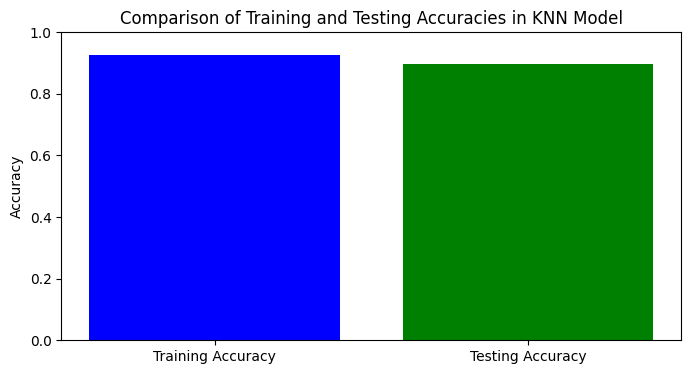

In [20]:
accuracies = [train_accuracy_knn, test_accuracy_knn]

plt.figure(figsize=(8, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Training and Testing Accuracies in KNN Model')
plt.ylim([0, 1]) 
plt.show()

## Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(x_train, y_train)
pred_dt = dt.predict(x_test)
dt_accuracy = dt.score(x_test, y_test)
dt_accuracy

0.9581673306772909

In [22]:
y_train_pred_dt = dt.predict(x_train)
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, pred_dt)

print("Training Accuracy: ", train_accuracy_dt)
print("Testing Accuracy: ", test_accuracy_dt)

Training Accuracy:  1.0
Testing Accuracy:  0.9581673306772909


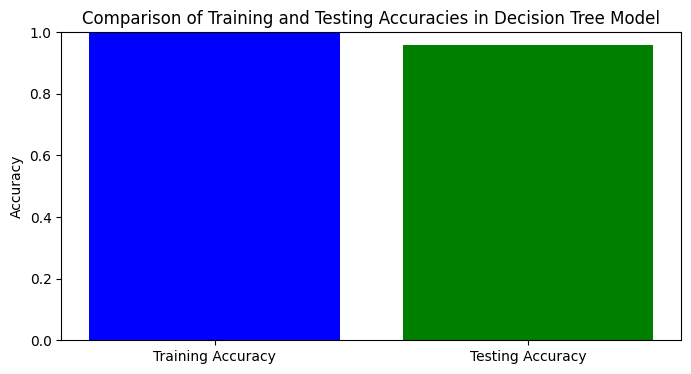

In [23]:
accuracies = [train_accuracy_dt, test_accuracy_dt]

plt.figure(figsize=(8, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Training and Testing Accuracies in Decision Tree Model')
plt.ylim([0, 1]) 
plt.show()

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
randf = RandomForestClassifier(random_state = 42)
randf.fit(x_train, y_train)
pred_randf = randf.predict(x_test)
randf_accuracy = randf.score(x_test, y_test)
randf_accuracy

0.9873837981407703

In [25]:
y_train_pred_rf = randf.predict(x_train)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, pred_randf)

print("Training Accuracy: ", train_accuracy_rf)
print("Testing Accuracy: ", test_accuracy_rf)

Training Accuracy:  1.0
Testing Accuracy:  0.9873837981407703


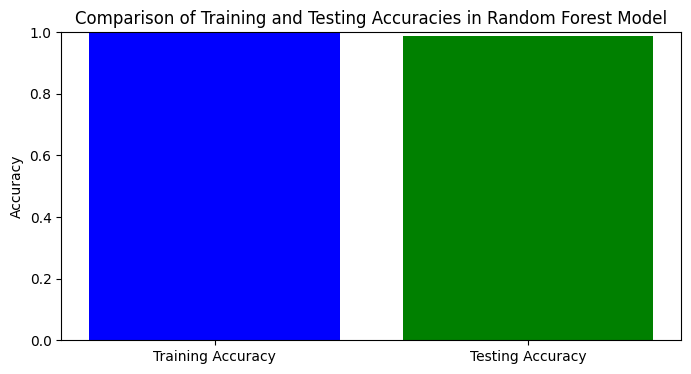

In [26]:
accuracies = [train_accuracy_rf, test_accuracy_rf]

plt.figure(figsize=(8, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Training and Testing Accuracies in Random Forest Model')
plt.ylim([0, 1]) 
plt.show()

In [27]:
import joblib as jb
# save models
jb.dump(knn, 'knn_model_5.joblib')
jb.dump(dt, 'dt_model_5.joblib')
jb.dump(randf, 'randf_model_5.joblib')

['randf_model_5.joblib']

In [28]:
# # load models
# knn_default = jb.load('knn.joblib')
# dt_default = jb.load('dt.joblib')
# randf_default = jb.load('randf.joblib')

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

      arabic       0.87      0.93      0.90       141
       dutch       0.87      1.00      0.93       119
     english       0.55      0.06      0.10       107
      french       0.91      0.97      0.94       107
      german       0.94      1.00      0.97       114
     italian       0.94      1.00      0.97       119
      korean       0.87      0.98      0.92       111
    mandarin       0.93      0.94      0.94       124
      polish       0.92      1.00      0.96       109
  portuguese       0.92      1.00      0.96       104
     russian       0.87      1.00      0.93       110
     spanish       0.81      0.74      0.78       124
     turkish       0.94      1.00      0.97       117

    accuracy                           0.90      1506
   macro avg       0.87      0.89      0.87      1506
weighted avg       0.87      0.90      0.87      1506



In [30]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

      arabic       0.97      1.00      0.98       141
       dutch       1.00      1.00      1.00       119
     english       0.96      0.46      0.62       107
      french       0.93      0.99      0.96       107
      german       0.97      1.00      0.98       114
     italian       0.99      1.00      1.00       119
      korean       0.98      1.00      0.99       111
    mandarin       0.95      1.00      0.98       124
      polish       0.96      1.00      0.98       109
  portuguese       0.95      1.00      0.98       104
     russian       0.94      1.00      0.97       110
     spanish       0.89      0.97      0.93       124
     turkish       0.97      1.00      0.98       117

    accuracy                           0.96      1506
   macro avg       0.96      0.96      0.95      1506
weighted avg       0.96      0.96      0.95      1506



In [31]:
print(classification_report(y_test, pred_randf))

              precision    recall  f1-score   support

      arabic       0.97      1.00      0.99       141
       dutch       1.00      1.00      1.00       119
     english       0.95      0.87      0.91       107
      french       1.00      0.99      1.00       107
      german       1.00      1.00      1.00       114
     italian       1.00      1.00      1.00       119
      korean       0.99      1.00      1.00       111
    mandarin       0.98      1.00      0.99       124
      polish       0.99      1.00      1.00       109
  portuguese       1.00      1.00      1.00       104
     russian       1.00      1.00      1.00       110
     spanish       0.96      0.97      0.96       124
     turkish       0.99      1.00      1.00       117

    accuracy                           0.99      1506
   macro avg       0.99      0.99      0.99      1506
weighted avg       0.99      0.99      0.99      1506



# CNN

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [33]:
X = np.array(df_shuffled.drop('label', axis=1).values)  
y = df_shuffled['label'].values

In [34]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_onehot = to_categorical(y_encoded)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

In [36]:
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [37]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1], 1)  

model = build_cnn_model(input_shape)
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


189/189 - 3s - 13ms/step - accuracy: 0.1048 - loss: 3.6200 - val_accuracy: 0.1541 - val_loss: 2.4977
Epoch 2/150
189/189 - 1s - 5ms/step - accuracy: 0.1249 - loss: 2.5043 - val_accuracy: 0.1660 - val_loss: 2.4385
Epoch 3/150
189/189 - 1s - 3ms/step - accuracy: 0.1578 - loss: 2.4527 - val_accuracy: 0.2105 - val_loss: 2.3719
Epoch 4/150
189/189 - 1s - 3ms/step - accuracy: 0.1779 - loss: 2.4033 - val_accuracy: 0.2331 - val_loss: 2.3005
Epoch 5/150
189/189 - 1s - 3ms/step - accuracy: 0.1920 - loss: 2.3372 - val_accuracy: 0.2742 - val_loss: 2.2384
Epoch 6/150
189/189 - 1s - 3ms/step - accuracy: 0.2257 - loss: 2.2724 - val_accuracy: 0.3008 - val_loss: 2.1416
Epoch 7/150
189/189 - 1s - 3ms/step - accuracy: 0.2458 - loss: 2.2152 - val_accuracy: 0.3559 - val_loss: 2.0487
Epoch 8/150
189/189 - 1s - 3ms/step - accuracy: 0.2745 - loss: 2.1336 - val_accuracy: 0.3592 - val_loss: 1.9817
Epoch 9/150
189/189 - 1s - 3ms/step - accuracy: 0.2833 - loss: 2.0800 - val_accuracy: 0.3818 - val_loss: 1.8937
Epo

In [38]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9411 - loss: 0.2160
Test Loss: 0.19827350974082947
Test Accuracy: 0.944887101650238


## Plotting Accuracy & Loss of CNN Before Hyperparameter Tuned

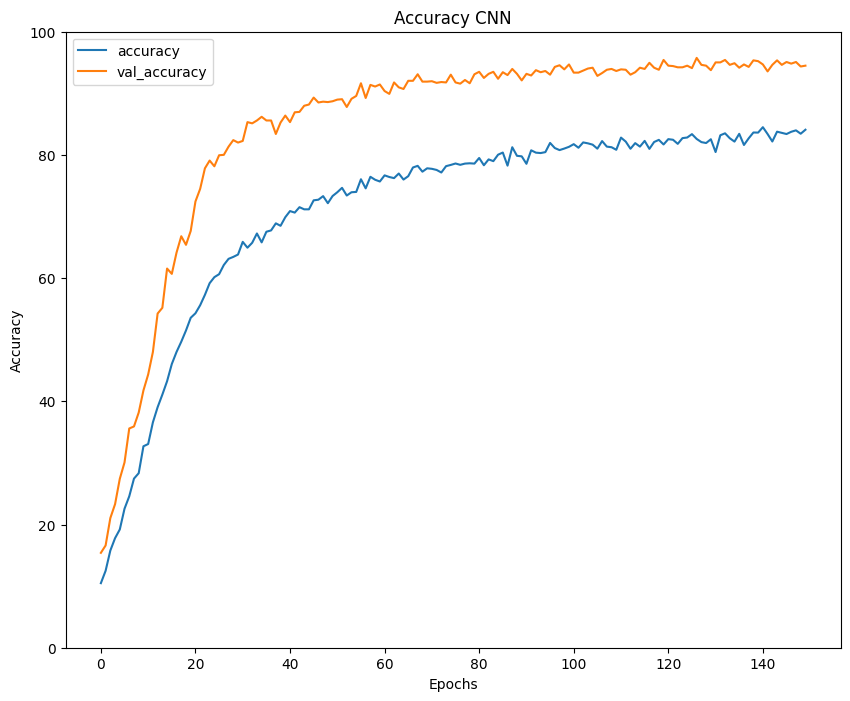

In [39]:
metrics = history.history

plt.figure(figsize=(10,8))
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.title("Accuracy CNN")
plt.ylim([0,100])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

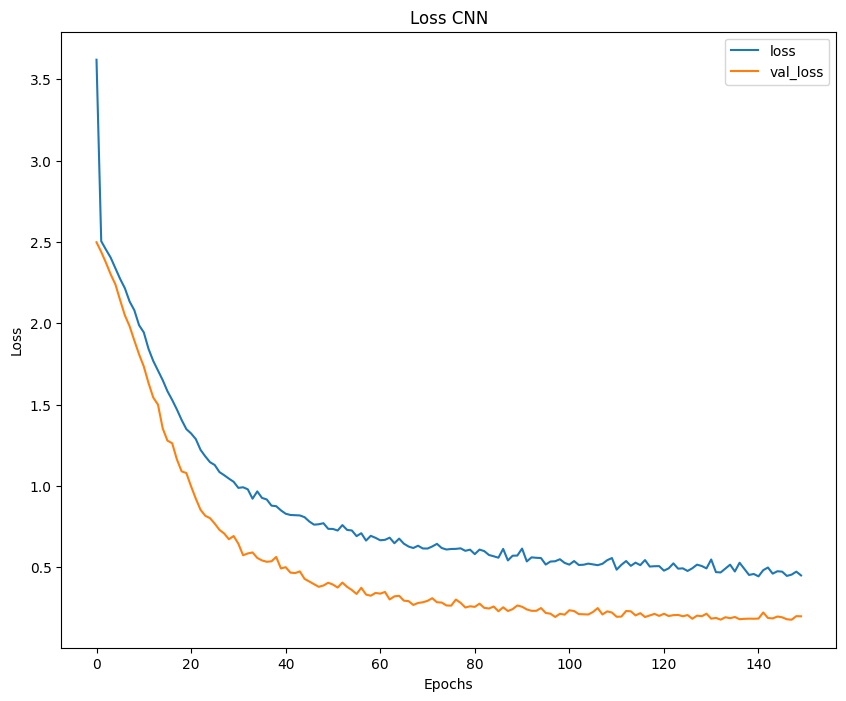

In [40]:
plt.figure(figsize=(10,8))
plt.plot(history.epoch, np.array(metrics['loss']), np.array(metrics['val_loss']))
plt.title("Loss CNN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['loss', 'val_loss'])
plt.show()

In [41]:
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [42]:
y_true = np.argmax(y_test, axis=1)

In [43]:
from sklearn.metrics import classification_report

class_names = [
    "Arabic", "Dutch", "English", "French", "German", 
    "Italian", "Korean", "Mandarin", "Polish", "Portuguese", 
    "Russian", "Spanish", "Turkish"
]

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

      Arabic       0.93      0.96      0.95       141
       Dutch       0.95      1.00      0.98       119
     English       0.73      0.60      0.66       107
      French       0.95      0.95      0.95       107
      German       1.00      1.00      1.00       114
     Italian       1.00      1.00      1.00       119
      Korean       0.98      0.98      0.98       111
    Mandarin       0.95      1.00      0.98       124
      Polish       0.98      1.00      0.99       109
  Portuguese       0.96      1.00      0.98       104
     Russian       0.92      0.97      0.95       110
     Spanish       0.87      0.80      0.83       124
     Turkish       1.00      1.00      1.00       117

    accuracy                           0.94      1506
   macro avg       0.94      0.94      0.94      1506
weighted avg       0.94      0.94      0.94      1506



In [44]:
model.save('cnn.h5')

In [45]:
from tensorflow.keras.models import load_model

model = load_model('cnn.h5')

In [46]:
model.save('cnn_model.keras')  # TensorFlow will use the SavedModel format by default


## Hyperparameter Tuning

In [47]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Conv1D(
            filters=hp.Int('filters1', min_value=32, max_value=128, step=32),
            kernel_size=hp.Int('kernel_size1', min_value=2, max_value=5, step=1),
            activation='relu',
            padding='same',
            input_shape=self.input_shape
        ))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(
            filters=hp.Int('filters2', min_value=64, max_value=256, step=32),
            kernel_size=hp.Int('kernel_size2', min_value=2, max_value=5, step=1),
            activation='relu',
            padding='same'
        ))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(
            hp.Int('dense_units', min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

/tmp/ipykernel_18/670177796.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6 
)

In [49]:
from kerastuner.tuners import RandomSearch

input_shape = (X_train.shape[1], 1) 
num_classes = y_train.shape[1] 

hypermodel = CNNHyperModel(input_shape=input_shape, num_classes=num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='model_tuning',
    project_name='AccentClassification'
)

tuner.search(x=X_train, y=y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopper, reduce_lr])

Trial 20 Complete [00h 01m 58s]
val_accuracy: 0.9113546013832092

Best val_accuracy So Far: 0.9770916402339935
Total elapsed time: 00h 26m 53s


In [50]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)
print("Best model accuracy: {:.2f}%".format(accuracy * 100))

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9785 - loss: 0.1302
Best model accuracy: 98.07%


In [51]:
# Creating CNN model with the optimized parameter from the start
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv1D(filters=32, kernel_size=4, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.0011876), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

best_model = create_cnn_model(input_shape, num_classes)

# Train data again from the start
history = best_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/150
189/189 - 3s - 15ms/step - accuracy: 0.1294 - loss: 3.1338 - val_accuracy: 0.1521 - val_loss: 2.4408
Epoch 2/150
189/189 - 1s - 5ms/step - accuracy: 0.1829 - loss: 2.4090 - val_accuracy: 0.2344 - val_loss: 2.3038
Epoch 3/150
189/189 - 1s - 5ms/step - accuracy: 0.2883 - loss: 2.1492 - val_accuracy: 0.3725 - val_loss: 1.9570
Epoch 4/150
189/189 - 1s - 5ms/step - accuracy: 0.4184 - loss: 1.7998 - val_accuracy: 0.5232 - val_loss: 1.5529
Epoch 5/150
189/189 - 1s - 5ms/step - accuracy: 0.5527 - loss: 1.4041 - val_accuracy: 0.6434 - val_loss: 1.1967
Epoch 6/150
189/189 - 1s - 5ms/step - accuracy: 0.6609 - loss: 1.0641 - val_accuracy: 0.7782 - val_loss: 0.7991
Epoch 7/150
189/189 - 1s - 5ms/step - accuracy: 0.7597 - loss: 0.7745 - val_accuracy: 0.8327 - val_loss: 0.6189
Epoch 8/150
189/189 - 1s - 5ms/step - accuracy: 0.8185 - loss: 0.5901 - val_accuracy: 0.8579 - val_loss: 0.4982
Epoch 9/150
189/189 - 1s - 5ms/step - accuracy: 0.8655 - loss: 0.4493 - val_accuracy: 0.9011 - val_loss

## Plotting Accuracy & Loss CNN After Hyperparameter Tuned

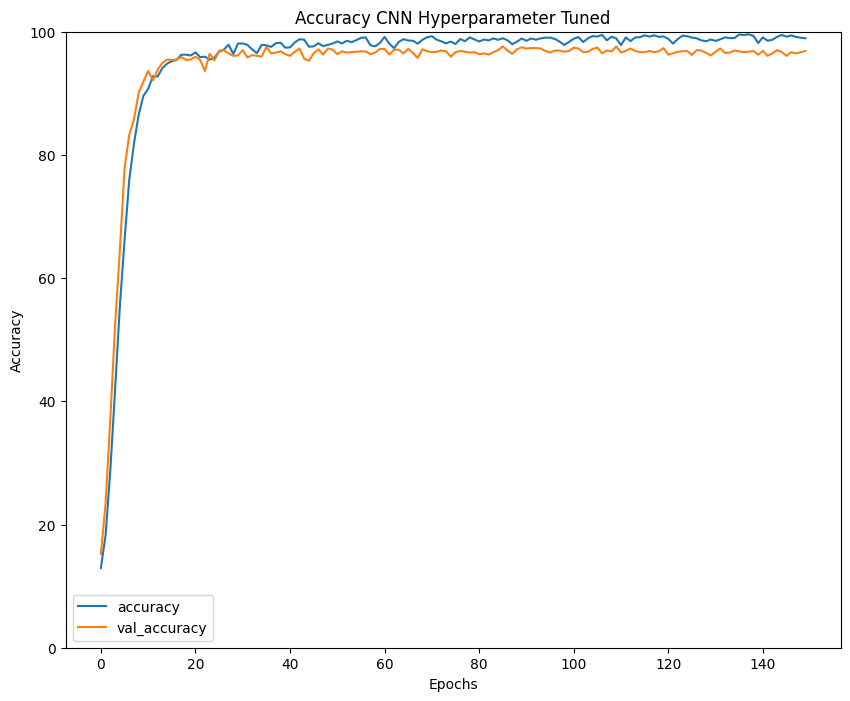

In [52]:
metrics = history.history

plt.figure(figsize=(10,8))
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.title("Accuracy CNN Hyperparameter Tuned")
plt.ylim([0,100])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

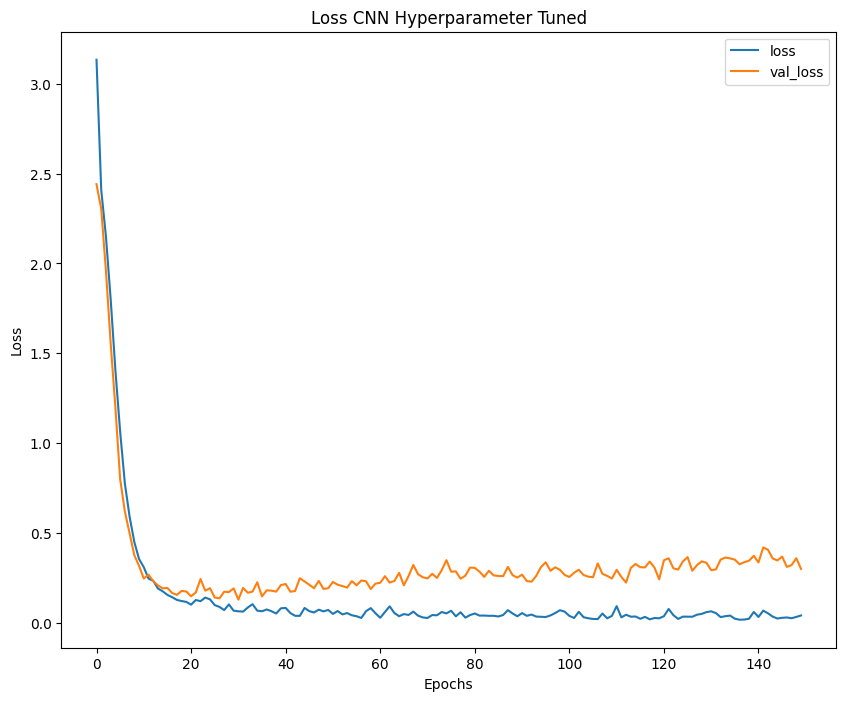

In [53]:
plt.figure(figsize=(10,8))
plt.plot(history.epoch, np.array(metrics['loss']), np.array(metrics['val_loss']))
plt.title("Loss CNN Hyperparameter Tuned")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['loss', 'val_loss'])
plt.show()

In [54]:
import numpy as np

# Predict the probabilities for each class
y_pred_probs = best_model.predict(X_test)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [55]:
from sklearn.metrics import classification_report

class_names = [
    "Arabic", "Dutch", "English", "French", "German", 
    "Italian", "Korean", "Mandarin", "Polish", "Portuguese", 
    "Russian", "Spanish", "Turkish"
]

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

      Arabic       0.95      1.00      0.98       141
       Dutch       0.98      1.00      0.99       119
     English       0.93      0.61      0.73       107
      French       0.93      0.99      0.96       107
      German       0.99      1.00      1.00       114
     Italian       1.00      1.00      1.00       119
      Korean       0.95      1.00      0.97       111
    Mandarin       0.97      1.00      0.98       124
      Polish       0.98      1.00      0.99       109
  Portuguese       0.99      1.00      1.00       104
     Russian       0.98      1.00      0.99       110
     Spanish       0.94      0.97      0.96       124
     Turkish       0.99      1.00      1.00       117

    accuracy                           0.97      1506
   macro avg       0.97      0.97      0.96      1506
weighted avg       0.97      0.97      0.97      1506



In [56]:
# Save the model
best_model.save('cnn_tunning.h5') 
loaded_model = load_model('cnn_tunning.h5') 
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print("Loaded model accuracy:", accuracy)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9622 - loss: 0.4520
Loaded model accuracy: 0.9687914848327637


In [57]:
best_model.save('cnn_tunning_keras.keras') 

In [58]:
from tensorflow.keras.models import load_model

# Load the best model you saved earlier
model = load_model('/kaggle/working/cnn_tunning.h5')

In [59]:
def preprocess_audio(file_path, target_sample_rate=44100, n_mfcc=13):
    # Load data
    y, sr = librosa.load(file_path, sr=target_sample_rate)
    
    # Extract MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Normalize MFCC
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
    mfcc = mfcc.T
    
    # Get 13 MFCC coefficients
    if mfcc.shape[0] > 13:
        mfcc = mfcc[:13, :]
    else:
        # Padd with zeros if coefficients are less than 13
        mfcc = np.pad(mfcc, ((0, 13 - mfcc.shape[0]), (0, 0)), mode='constant')
    mfcc = np.mean(mfcc, axis=1, keepdims=True)
    
    # Expand dimensions to match the input shape of the model (batch_size, time_steps, features)
    mfcc = np.expand_dims(mfcc, axis=0)
    
    return mfcc

In [60]:
file_path = '/kaggle/input/speech-accent-archive/recordings/recordings/english2.mp3'

# Preprocess the audio
audio_data = preprocess_audio(file_path)
print("Shape of preprocessed audio data:", audio_data.shape) 

Shape of preprocessed audio data: (1, 13, 1)


In [61]:
predictions = model.predict(audio_data)

predicted_class = np.argmax(predictions, axis=1)

class_names = [
    "Arabic", "Dutch", "English", "French", "German", 
    "Italian", "Korean", "Mandarin", "Polish", "Portuguese", 
    "Russian", "Spanish", "Turkish"
]

print(f"The predicted class for the audio file is: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
The predicted class for the audio file is: Arabic


In [62]:
model.save('cnn_tunning.h5')

In [63]:
import tensorflow as tf
from joblib import load

def load_model(model_name):
    if model_name.endswith('.h5'):
        model = tf.keras.models.load_model(model_name)
    else:
        model = load(f'{model_name}.joblib')
    return model

load_model('/kaggle/working/cnn_tunning.h5')

<Sequential name=sequential_1, built=True>